# Objective: Apply Logistic regression with CountVectorizer Features, including both unigrams and bigrams

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,LabelBinarizer

# Reading the Gene and Variation Data

In [3]:
data=pd.read_csv('training_variants')
print('Number of the Data points : ',data.shape[0])
print('Number of the Features : ',data.shape[1])
print('Features :',data.columns.values)
data.head()

Number of the Data points :  3321
Number of the Features :  4
Features : ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


# Reading the Text data

In [4]:
text_data=pd.read_csv('training_text',sep='\|\|',names=['ID','TEXT'],engine='python',skiprows=1)
print('Number of data points : ', text_data.shape[0])
print('Number of features : ', text_data.shape[1])
print('Features : ', text_data.columns.values)
text_data.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


# Data Preprocessing

In [5]:
stop_words=set(stopwords.words('english'))
def text_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string=""
        # replace every special char with space
        total_text=re.sub('[^a-zA-Z0-9\n]',' ',str(total_text))
        #Repalce multiple space with single space
        total_text=re.sub('\s+',' ',total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        text_data[column][index] = string       

In [6]:
#text processing stage.
start_time = time.clock()
for index, row in text_data.iterrows():
    text_preprocessing(row['TEXT'], index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 413.218443504075 seconds


# Merging the text data with Gene and Variation

In [7]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, text_data,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


# Spliting the dataset into Train,Test and CV

In [8]:
y_true=result['Class'].values
result.Variation = result.Variation.str.replace('\s+', '_')
result.Gene=result.Gene.str.replace('\s+','_')
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [9]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


# Featurize the Gene feature

In [10]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

# Featurize the Variation Feature

In [11]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [12]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1963)


# Featurizing the text data using Bigram

In [13]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(ngram_range=(1,2),min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 766125


In [14]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)






In [31]:
def plot_confusion_matrix(test_y,predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()        

In [15]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [16]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

# Stacking all the features 

In [17]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


In [18]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 768320)
(number of data points * number of features) in test data =  (665, 768320)
(number of data points * number of features) in cross validation data = (532, 768320)


for lambda = 1e-06
Log Loss : 1.3436476231584666
for lambda = 1e-05
Log Loss : 1.3408471177647645
for lambda = 0.0001
Log Loss : 1.3193567383117006
for lambda = 0.001
Log Loss : 1.2709936553217325
for lambda = 0.01
Log Loss : 1.2226312978176839
for lambda = 0.1
Log Loss : 1.1802022115504942
for lambda = 1
Log Loss : 1.1655139131751364
for lambda = 10
Log Loss : 1.1640501726361312
for lambda = 100
Log Loss : 1.1626820959415523


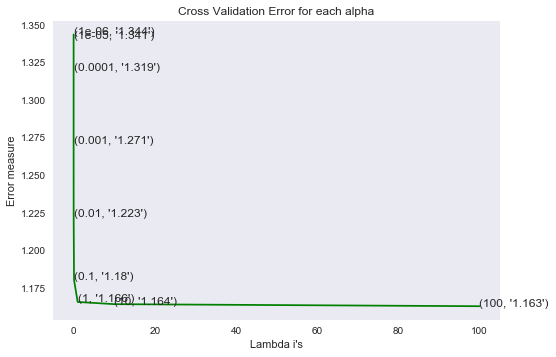

For values of best alpha =  100 The train log loss is: 0.5046707932976987
For values of best alpha =  100 The cross validation log loss is: 1.1626820959415523
For values of best alpha =  100 The test log loss is: 1.0982695082164882


In [29]:
c = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in c:
    print("for lambda =", i)
    clf = LogisticRegression(class_weight='balanced',C=i,random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(c, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((c[i],str(txt)), (c[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Lambda i's")
plt.ylabel("Error measure")
plt.show()


best_lambda = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced',C=c[best_lambda],random_state=42,penalty='l2')
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', c[best_lambda], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', c[best_lambda], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', c[best_lambda], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
clf = LogisticRegression(class_weight='balanced', C=c[best_lambda], penalty='l2',random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Using Only 1000 features and Bi-gram

# Collecting top 1000 Features

In [22]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_words=list(sorted_text_fea_dict.keys())
sorted_words_1000=sorted_words[0:1000]

In [24]:
text_token=CountVectorizer(ngram_range=(1,2),vocabulary=sorted_words_1000)
train_text_feature_onehotCoding_1000=text_token.fit_transform(train_df['TEXT'])

# don't forget to normalize every feature
train_text_feature_onehotCoding_1000 = normalize(train_text_feature_onehotCoding_1000, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_1000 = text_token.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_1000 = normalize(test_text_feature_onehotCoding_1000, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_1000 = text_token.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_1000 = normalize(cv_text_feature_onehotCoding_1000, axis=0)

In [25]:
train_x_onehotCoding_1000 = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_1000)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding_1000 = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_1000)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding_1000 = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_1000)).tocsr()
cv_y = np.array(list(cv_df['Class']))

# Tunning the hyperParameter

for lambda = 1e-06
Log Loss : 1.7921287961349752
for lambda = 1e-05
Log Loss : 1.791871470714991
for lambda = 0.0001
Log Loss : 1.78931417446693
for lambda = 0.001
Log Loss : 1.7600368860922406
for lambda = 0.01
Log Loss : 1.4023149815685156
for lambda = 0.1
Log Loss : 1.1789074349983375
for lambda = 1
Log Loss : 1.0458714659071948
for lambda = 10
Log Loss : 0.9952269872365339
for lambda = 100
Log Loss : 0.9944669639862437


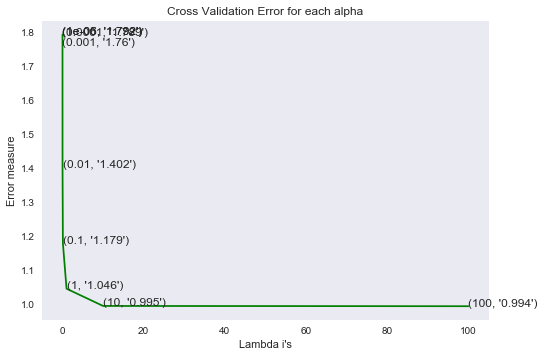

For values of best alpha =  100 The train log loss is: 0.3778301668772109
For values of best alpha =  100 The cross validation log loss is: 0.9944669639862437
For values of best alpha =  100 The test log loss is: 0.9493472788273823


In [27]:
c = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in c:
    print("for lambda =", i)
    clf = LogisticRegression(class_weight='balanced',C=i,random_state=42)
    clf.fit(train_x_onehotCoding_1000, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_1000, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_1000)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(c, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((c[i],str(txt)), (c[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Lambda i's")
plt.ylabel("Error measure")
plt.show()


best_lambda = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced',C=c[best_lambda],random_state=42,penalty='l2')
clf.fit(train_x_onehotCoding_1000, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_1000, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_1000)
print('For values of best alpha = ', c[best_lambda], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_1000)
print('For values of best alpha = ', c[best_lambda], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_1000)
print('For values of best alpha = ', c[best_lambda], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.9944669639862437
Number of mis-classified points : 0.34210526315789475
-------------------- Confusion matrix --------------------


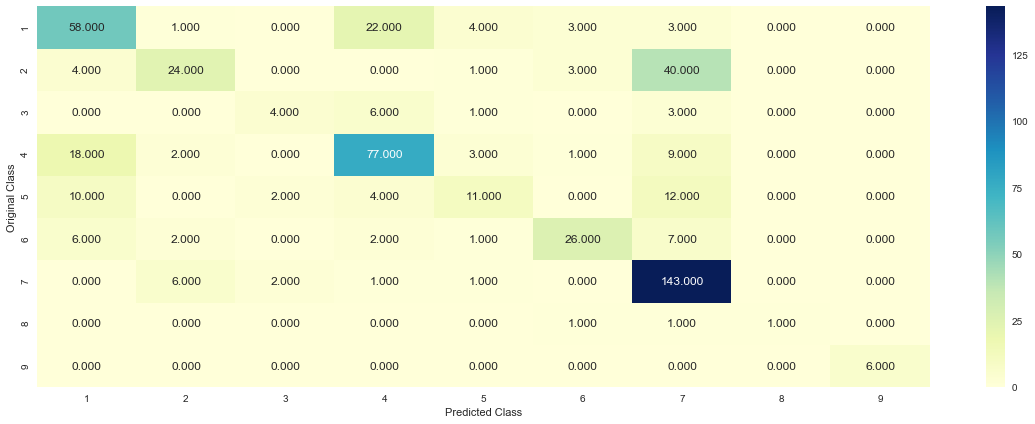

-------------------- Precision matrix (Columm Sum=1) --------------------


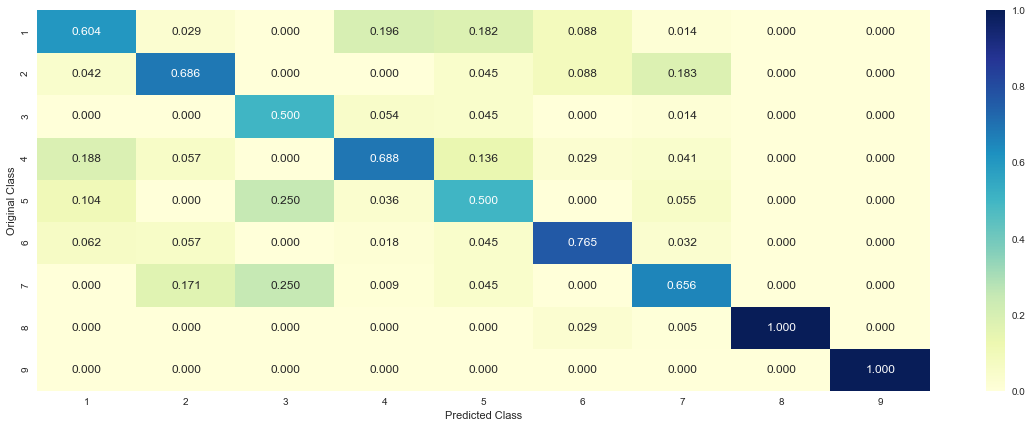

-------------------- Recall matrix (Row sum=1) --------------------


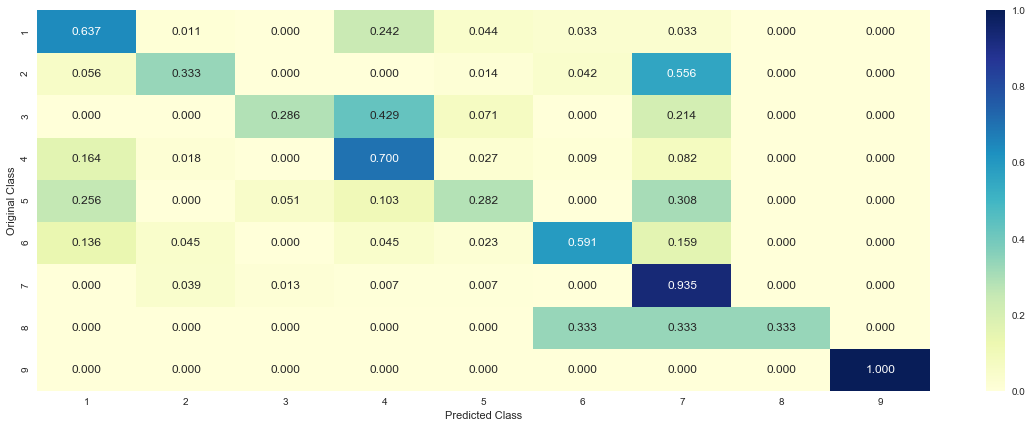

In [32]:
clf = LogisticRegression(class_weight='balanced', C=c[best_lambda], penalty='l2',random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding_1000, train_y, cv_x_onehotCoding_1000, cv_y, clf)

In [6]:
data={'Train Loss':[0.504,0.377],'CV Loss':[1.162,0.9944],'Test Loss':[1.091,0.9493]}
pd.DataFrame(data,index=['Logistic Regression(Bigram)','Logisticb Regression(Bigram with 1000 features)'])

,Train Loss,CV Loss,Test Loss
Logistic Regression(Bigram),0.504,1.1620,1.0910
Logisticb Regression(Bigram with 1000 features),0.377,0.9944,0.9493


# Observation: As you can see that , by selecting top 1000 features and using Bigram We are able to reduce the CV Loss and Test Lossto the less than 1
     